In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

from torch.distributions.log_normal import LogNormal
from sklearn.tree import DecisionTreeRegressor
from ngboost import SurvNGBoost, NGBoost
from experiments.evaluation import calculate_concordance_naive

from ngboost.scores import MLE_surv, CRPS_surv

In [2]:
def create_cov_matrix(num_vars, cov_strength):
    cov = np.zeros((num_vars, num_vars), dtype=float)
    for i, j in np.ndindex(cov.shape):
        cov[i, j] = cov_strength[i] * cov_strength[j]
        cov[range(num_vars), range(num_vars)] = 1
    return cov

In [3]:
def simulate_X(num_normal=5, normal_cov_strength=[0.1,0.3,0.8,0.9,0.5], num_unif=1, num_bi=2, N=10):
    cov_normal = create_cov_matrix(num_normal, normal_cov_strength)
    X = sp.stats.multivariate_normal.rvs(cov=cov_normal, size=N)
    for i in range(num_unif):
        X_uniform = sp.stats.uniform.rvs(loc=0, scale=1, size=N)
        X = np.hstack((X, [[a] for a in X_uniform]))
    for i in range(num_bi):
        X_bino = np.random.binomial(1, 0.5, size=N)
        X = np.hstack((X, [[a] for a in X_bino]))
    return X

In [4]:
'''
A set of functions for parameters
'''
def f_const(X, const):
    '''
    A contant function of X. 
    '''
    return [const] * len(X)

def f_linear(X, coef):
    '''
    A linear function of X.
    coef :: a list of coefficients for covariates of X
    '''
    return np.sum(coef * X, axis=1)

def f_linear_exp(X, coef):
    '''
    A linear exponential function of X. Note that might need to adjust expectation.
    coef :: a list of coefficients for covariates of X
    '''
    return np.sum(coef ** X, axis=1)

def f_custom(X):
    '''
    A non-linear non-monotonic fucntion of X.
    '''
    pnorm = norm.cdf
    res = 4 * (X[:,0] > 1) * (X[:,1] > 0) + 4 * (X[:,2] > 1) * (X[:,3] > 0) + \
            2 * X[:,4] * X[:,0] - 4 * pnorm(-1) #adjust expectation
    return res

In [81]:
def simulate_Y_C(X, D = sp.stats.lognorm, D_config={'s':1, 'scale':1, 'loc':0}):

    ''' 
    Input:
    D :: conditional outcome distribtuion, can choose from sp.stats.genextreme, sp.stats.lognorm, and etc
    D_config :: parameters of the distribution, each can be generated by a customized function,
                such as f_const, f_linear, f_linear_exp, f_custom
    
    Returns: (Y, X)
    '''
    
    n_observations = len(X)
    D_s = abs(f_custom(X))
    D_loc = f_const(X, 2)
    D_config['s'] = D_s
    D_config['loc'] = D_loc
    T = D.rvs(s=D_config['s'], scale=D_config['scale'], loc=D_config['loc'], size=n_observations)
    U = D.rvs(s=1, scale=1, loc=0, size=n_observations)
    Y = np.minimum(T, U)
    C = (T > U)*1.0
    return Y, C

In [6]:
def create_df(X, Y, C, num):
    df = pd.DataFrame(X, columns=["X%d" % i for i in range(X.shape[1])])
    df["Y"] = Y
    df["C"] = C
    df = df.sample(frac=1, replace=False)
    train_file = 'data/simulated/sim_data_train_' + str(num) + '.csv'
    test_file = 'data/simulated/sim_data_test_' + str(num) + '.csv'
    df.iloc[:700].to_csv(train_file, index=False)
    df.iloc[700:].to_csv(test_file, index=False)

In [89]:
def run_experiments(df_train_filename, df_test_filename, natural_gradient = False,
                   second_order = False, quadrant_search = False):
    df_train = pd.read_csv(df_train_filename)
    df_test = pd.read_csv(df_test_filename)
    
    Y = np.array(df_train['Y'])
    C = np.array(df_train['C'])
    X = np.array(df_train.drop(['Y', 'C'], axis=1))
    
    Y_test = np.array(df_test['Y'])
    C_test = np.array(df_test['C'])
    X_test = np.array(df_test.drop(['Y', 'C'], axis=1))
    
    sb = SurvNGBoost(Base = lambda : DecisionTreeRegressor(criterion='mse'),
                     Dist = LogNormal,
                     Score = MLE_surv,
                     n_estimators = 1000,
                     learning_rate = 0.1,
                     natural_gradient = natural_gradient,
                     second_order = second_order,
                     quadrant_search = quadrant_search,
                     nu_penalty=1e-3)
    loss_train, loss_test = sb.fit(X, Y, C, X_test, Y_test, C_test)
    
    preds_train = sb.pred_mean(X)
    preds_test = sb.pred_mean(df_test.drop(["Y", "C"], axis=1))
    
    conc_train = calculate_concordance_naive(preds_train, Y, C)
    conc_test = calculate_concordance_naive(preds_test, df_test["Y"], df_test["C"])
    
    test_true_mean = np.mean(df_test["Y"])
    test_pred_mean = np.mean(preds_test)
    
    train_kl = sp.stats.entropy(preds_train, qk=Y)
    test_kl = sp.stats.entropy(preds_test, qk=df_test["Y"])
    return loss_train, loss_test, conc_test, conc_train, test_kl, train_kl

### Simulationa Scenario
$n = 1000$ <br>
$p = 90$ <br>
$P(Y|X) = \text{LogNormal}(0,1)$, i.e. constant functions for each distribution parameter <br>
$P(C|X) = \text{LogNormal}(0,1)$

In [38]:
X = simulate_X(num_unif=30, num_bi=30, N=1000, num_normal=30, normal_cov_strength=[0.5]*30)

In [39]:
Y, C = simulate_Y_C(X)

In [40]:
print('Censoring fraction : %f' % ((np.sum(C) / len(C))))

Censoring fraction : 0.505000


In [41]:
create_df(X, Y, C, 1)

In [42]:
df_train_filename = 'data/simulated/sim_data_train_1.csv'
df_test_filename = 'data/simulated/sim_data_test_1.csv'

In [72]:
loss_train, loss_test, conc_test, conc_train, test_kl, train_kl = \
run_experiments(df_train_filename, df_test_filename)

Fitting marginal distribution, until convergence...
Initial params:  [array(-0.1910282, dtype=float32), array(-0.25885344, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 111.96it/s]


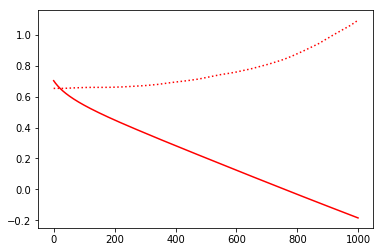

In [51]:
plt.plot(range(len(loss_train)), loss_train, label='Vanilla Train', color='red', linestyle="-")
plt.plot(range(len(loss_test)), loss_test, label='Vanilla Test', color='red', linestyle=":")

In [73]:
loss_train_n, loss_test_n, conc_test_n, conc_train_n, test_kl_n, train_kl_n = \
run_experiments(df_train_filename, df_test_filename, natural_gradient=True)

Fitting marginal distribution, until convergence...
Initial params:  [array(-0.1910282, dtype=float32), array(-0.25885344, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 113.87it/s]


In [74]:
loss_train_s, loss_test_s, conc_test_s, conc_train_s, test_kl_s, train_kl_s = \
run_experiments(df_train_filename, df_test_filename, natural_gradient=True, second_order=True)

Fitting marginal distribution, until convergence...
Initial params:  [array(-0.1910282, dtype=float32), array(-0.25885344, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 111.39it/s]


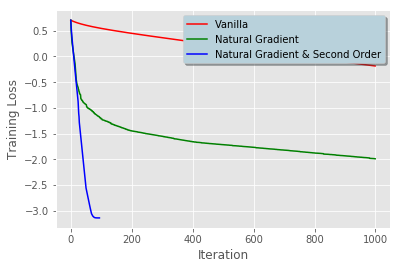

In [69]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(range(len(loss_train)), loss_train, label='Vanilla', color='red')
ax.plot(range(len(loss_train_n)), loss_train_n, label='Natural Gradient', color = 'green')
ax.plot(range(len(loss_train_s)), loss_train_s, label='Natural Gradient & Second Order', color = 'blue')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
legend.get_frame().set_facecolor('#b8d1db')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('NGBoosting (MLE)')
plt.show()

#plt.plot(range(len(loss_train_q)), loss_train_q)

In [70]:
print("="*30 + '  CRPS  ' + "="*30)
print('Vanilla: Train concordance %f Test concordance %f' % (conc_train, conc_test))
print('Natural gradient: Train concordance %f Test concordance %f' % (conc_train_n, conc_test_n))
print('Natural gradient & second order: Train concordance %f Test concordance %f' % (conc_train_s, conc_test_s))

Vanilla: Train concordance 0.927567 Test concordance 0.516617
Natural gradient: Train concordance 0.999347 Test concordance 0.521302
Natural gradient & second order: Train concordance 0.999863 Test concordance 0.506280


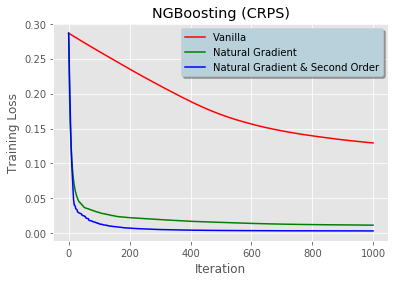

In [75]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(range(len(loss_train)), loss_train, label='Vanilla', color='red')
ax.plot(range(len(loss_train_n)), loss_train_n, label='Natural Gradient', color = 'green')
ax.plot(range(len(loss_train_s)), loss_train_s, label='Natural Gradient & Second Order', color = 'blue')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
legend.get_frame().set_facecolor('#b8d1db')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('NGBoosting (CRPS)')
plt.show()

#plt.plot(range(len(loss_train_q)), loss_train_q)

In [78]:
print("="*30 + '  CRPS  ' + "="*30)
print('Vanilla: Train concordance %f Test concordance %f' % (conc_train, conc_test))
print('Natural gradient: Train concordance %f Test concordance %f' % (conc_train_n, conc_test_n))
print('Natural gradient & second order: Train concordance %f Test concordance %f' % (conc_train_s, conc_test_s))

==============================  CRPS  ==============================
Vanilla: Train concordance 0.955230 Test concordance 0.537533
Natural gradient: Train concordance 0.999919 Test concordance 0.495266
Natural gradient & second order: Train concordance 1.000000 Test concordance 0.474833


In [ ]:
loss_train_q, conc_test_q, test_true_mean_q, test_pred_mean_q = \
run_experiments(df_train_filename, df_test_filename, natural_gradient=True, second_order=True, quadrant_search=True)

### Simulationa Scenario
$n = 1000$ <br>
$p = 300$ <br>
$P(Y|X) = \text{LogNormal}(a,b)$ with a ~ linear and b ~ non-linear and non-monotone <br>
$P(C|X) = \text{LogNormal}(0,1)$

In [82]:
X = simulate_X(num_unif=100, num_bi=100, N=1000, num_normal=100, normal_cov_strength=[0.5]*100)

In [83]:
Y, C = simulate_Y_C(X)

In [85]:
print('Censoring fraction: %f' % ((np.sum(C) / len(C))))

Censoring fraction: 0.875000


In [86]:
create_df(X, Y, C, 2)

In [87]:
df_train_filename = 'data/simulated/sim_data_train_2.csv'
df_test_filename = 'data/simulated/sim_data_test_2.csv'

In [90]:
loss_train, loss_test, conc_test, conc_train, test_kl, train_kl = \
run_experiments(df_train_filename, df_test_filename)

Fitting marginal distribution, until convergence...
Initial params:  [array(1.1782559, dtype=float32), array(-1.1488739, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 145.36it/s]


In [91]:
loss_train_n, loss_test_n, conc_test_n, conc_train_n, test_kl_n, train_kl_n = \
run_experiments(df_train_filename, df_test_filename, natural_gradient=True)

Fitting marginal distribution, until convergence...
Initial params:  [array(1.1782559, dtype=float32), array(-1.1488739, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 141.79it/s]


In [92]:
loss_train_s, loss_test_s, conc_test_s, conc_train_s, test_kl_s, train_kl_s = \
run_experiments(df_train_filename, df_test_filename, natural_gradient=True, second_order=True)

Fitting marginal distribution, until convergence...
Initial params:  [array(1.1782559, dtype=float32), array(-1.1488739, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 144.19it/s]


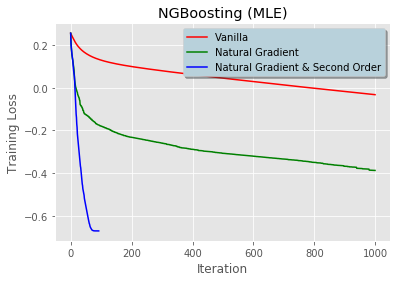

In [93]:
fig, ax = plt.subplots()
ax.plot(range(len(loss_train)), loss_train, label='Vanilla', color='red')
ax.plot(range(len(loss_train_n)), loss_train_n, label='Natural Gradient', color = 'green')
ax.plot(range(len(loss_train_s)), loss_train_s, label='Natural Gradient & Second Order', color = 'blue')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
legend.get_frame().set_facecolor('#b8d1db')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('NGBoosting (MLE)')
plt.show()

In [95]:
print("="*30 + '  MLE  ' + "="*30)
print('Vanilla: Train concordance %f Test concordance %f' % (conc_train, conc_test))
print('Natural gradient: Train concordance %f Test concordance %f' % (conc_train_n, conc_test_n))
print('Natural gradient & second order: Train concordance %f Test concordance %f' % (conc_train_s, conc_test_s))

==============================  MLE  ==============================
Vanilla: Train concordance 0.986244 Test concordance 0.431435
Natural gradient: Train concordance 1.000000 Test concordance 0.455696
Natural gradient & second order: Train concordance 0.998834 Test concordance 0.459916


In [111]:
loss_train_q, conc_test_q, test_true_mean_q, test_pred_mean_q = run_experiments(df_train_filename, df_test_filename, natural_gradient=True, second_order=True, quadrant_search=True)

Fitting marginal distribution, until convergence...
Initial params:  [array(1.0970538, dtype=float32), array(-1.2068466, dtype=float32)]


100%|██████████| 300/300 [00:02<00:00, 145.09it/s]
